In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
data_path = Path("../data")

In [13]:
df_final = pd.read_parquet(data_path / "engineered_data.parquet")

In [29]:
df_final[df_final['advertiser_zrive_id'] == 2]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_unique_published_ads,monthly_contracted_ads,monthly_leads,monthly_visits,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,monthly_pepitas_ads,monthly_shows,monthly_total_phone_views,monthly_total_calls,monthly_total_emails,monthly_total_invoice,monthly_unique_calls,monthly_unique_emails,monthly_unique_leads,monthly_avg_ad_price,monthly_distinct_ads,month_period,churn,tenure,months_since_last_contract,has_renewed,monthly_total_premium_ads,ratio_published_contracted,ratio_unique_published,ratio_premium_ads,leads_per_published_ad,leads_per_premium_ad,visits_per_published_ad,leads_per_visit,leads_per_shows,invoice_per_published_ad,invoice_per_lead,monthly_leads_3_months_mean,monthly_leads_3_months_mean_delta,monthly_visits_3_months_mean,monthly_visits_3_months_mean_delta,monthly_total_invoice_3_months_mean,monthly_total_invoice_3_months_mean_delta,monthly_avg_ad_price_3_months_mean,monthly_avg_ad_price_3_months_mean_delta,monthly_published_ads_3_months_mean,monthly_published_ads_3_months_mean_delta,monthly_contracted_ads_3_months_mean,monthly_contracted_ads_3_months_mean_delta,ratio_published_contracted_3_months_mean,ratio_published_contracted_3_months_mean_delta,ratio_unique_published_3_months_mean,ratio_unique_published_3_months_mean_delta,ratio_premium_ads_3_months_mean,ratio_premium_ads_3_months_mean_delta,leads_per_published_ad_3_months_mean,leads_per_published_ad_3_months_mean_delta,leads_per_premium_ad_3_months_mean,leads_per_premium_ad_3_months_mean_delta,visits_per_published_ad_3_months_mean,visits_per_published_ad_3_months_mean_delta,leads_per_visit_3_months_mean,leads_per_visit_3_months_mean_delta,leads_per_shows_3_months_mean,leads_per_shows_3_months_mean_delta,invoice_per_published_ad_3_months_mean,invoice_per_published_ad_3_months_mean_delta,invoice_per_lead_3_months_mean,invoice_per_lead_3_months_mean_delta
2,2,202301,31,31,150,4,17970.0,10,10,4,0,1250403.0,16,2,2,75.4,2,2,4,NaN,NaN,2023-01,0.0,28,28.0,1,24,0.206667,1.0,0.774194,0.129032,0.166667,579.677419,0.000223,0.000003,2.432258,18.850000,4.000000,0.000000,17970.0,0.0,75.400000,0.000000,NaN,NaN,31.000000,0.000000,150.0,0.0,0.206667,0.000000,1.0,0.0,0.774194,0.000000,0.129032,0.000000,0.166667,0.000000,579.677419,0.000000,0.000223,0.000000,0.000003,0.000000e+00,2.432258,0.000000,18.850000,0.000000
3,2,202302,31,31,150,4,10695.0,10,10,4,0,1026553.5,10,2,1,54.9,2,2,4,NaN,NaN,2023-02,0.0,29,29.0,1,24,0.206667,1.0,0.774194,0.129032,0.166667,345.000000,0.000374,0.000004,1.770968,13.725000,4.000000,0.000000,14332.5,-3637.5,65.150000,-10.250000,NaN,NaN,31.000000,0.000000,150.0,0.0,0.206667,0.000000,1.0,0.0,0.774194,0.000000,0.129032,0.000000,0.166667,0.000000,462.338710,-117.338710,0.000298,0.000076,0.000004,3.487824e-07,2.101613,-0.330645,16.287500,-2.562500
4,2,202303,47,47,150,6,7845.0,10,10,4,0,688947.0,16,5,1,34.3,4,1,5,NaN,NaN,2023-03,0.0,30,30.0,1,24,0.313333,1.0,0.510638,0.127660,0.250000,166.914894,0.000765,0.000009,0.729787,5.716667,4.666667,1.333333,12170.0,-4325.0,54.866667,-20.566667,NaN,NaN,36.333333,10.666667,150.0,0.0,0.242222,0.071111,1.0,0.0,0.686342,-0.175704,0.128575,-0.000915,0.194444,0.055556,363.864104,-196.949211,0.000454,0.000311,0.000005,3.440795e-06,1.644338,-0.914550,12.763889,-7.047222
5,2,202304,64,64,150,4,13275.0,10,10,4,0,1104043.5,17,1,2,61.7,1,3,4,NaN,NaN,2023-04,0.0,31,31.0,1,24,0.426667,1.0,0.375000,0.062500,0.166667,207.421875,0.000301,0.000004,0.964063,15.425000,4.666667,-0.666667,10605.0,2670.0,50.300000,11.400000,NaN,NaN,47.333333,16.666667,150.0,0.0,0.315556,0.111111,1.0,0.0,0.553277,-0.178277,0.106397,-0.043897,0.194444,-0.027778,239.778923,-32.357048,0.000480,-0.000179,0.000005,-1.786462e-06,1.154939,-0.190877,11.622222,3.802778
6,2,202305,79,79,150,16,16342.5,10,10,4,0,1044193.5,23,11,3,34.3,6,5,11,NaN,1.0,2023-05,0.0,32,32.0,1,24,0.526667,1.0,0.303797,0.202532,0.666667,206.867089,0.000979,0.000015,0.434177,2.143750,8.666667,7.333333,12487.5,3855.0,43.4333

In [28]:
df_final.tail()

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_unique_published_ads,monthly_contracted_ads,monthly_leads,monthly_visits,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,monthly_pepitas_ads,monthly_shows,monthly_total_phone_views,monthly_total_calls,monthly_total_emails,monthly_total_invoice,monthly_unique_calls,monthly_unique_emails,monthly_unique_leads,monthly_avg_ad_price,monthly_distinct_ads,month_period,churn,tenure,months_since_last_contract,has_renewed,monthly_total_premium_ads,ratio_published_contracted,ratio_unique_published,ratio_premium_ads,leads_per_published_ad,leads_per_premium_ad,visits_per_published_ad,leads_per_visit,leads_per_shows,invoice_per_published_ad,invoice_per_lead,monthly_leads_3_months_mean,monthly_leads_3_months_mean_delta,monthly_visits_3_months_mean,monthly_visits_3_months_mean_delta,monthly_total_invoice_3_months_mean,monthly_total_invoice_3_months_mean_delta,monthly_avg_ad_price_3_months_mean,monthly_avg_ad_price_3_months_mean_delta,monthly_published_ads_3_months_mean,monthly_published_ads_3_months_mean_delta,monthly_contracted_ads_3_months_mean,monthly_contracted_ads_3_months_mean_delta,ratio_published_contracted_3_months_mean,ratio_published_contracted_3_months_mean_delta,ratio_unique_published_3_months_mean,ratio_unique_published_3_months_mean_delta,ratio_premium_ads_3_months_mean,ratio_premium_ads_3_months_mean_delta,leads_per_published_ad_3_months_mean,leads_per_published_ad_3_months_mean_delta,leads_per_premium_ad_3_months_mean,leads_per_premium_ad_3_months_mean_delta,visits_per_published_ad_3_months_mean,visits_per_published_ad_3_months_mean_delta,leads_per_visit_3_months_mean,leads_per_visit_3_months_mean_delta,leads_per_shows_3_months_mean,leads_per_shows_3_months_mean_delta,invoice_per_published_ad_3_months_mean,invoice_per_published_ad_3_months_mean_delta,invoice_per_lead_3_months_mean,invoice_per_lead_3_months_mean_delta
56330,6824,202408,8,8,10,0,3232.5,0,0,0,0,30628.5,0,0,0,0.0,0,0,0,29962.00,10.0,2024-08,0.0,19,19.0,0,0,0.8,1.0,0.0,0.000000,0.0,404.062500,0.000000,0.000000,0.0,0.0,0.666667,-0.666667,3475.0,-242.5,0.0,0.0,30130.776667,-168.776667,8.666667,-0.666667,10.0,0.0,0.866667,-0.066667,1.0,0.0,0.0,0.0,0.074074,-0.074074,0.0,0.0,401.076389,2.986111,0.000169,-0.000169,0.000017,-0.000017,0.0,0.0,0.0,0.0
56331,6824,202409,7,7,10,0,1980.0,0,0,0,0,20244.0,0,0,0,0.0,0,0,0,30990.00,8.0,2024-09,0.0,20,20.0,0,0,0.7,1.0,0.0,0.000000,0.0,282.857143,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2822.5,-842.5,0.0,0.0,30788.443333,201.556667,8.000000,-1.000000,10.0,0.0,0.800000,-0.100000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,349.528770,-66.671627,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
56332,6824,202410,6,6,10,0,2070.0,0,0,0,0,19299.0,0,0,0,0.0,0,0,0,33002.86,7.0,2024-10,0.0,21,21.0,0,0,0.6,1.0,0.0,0.000000,0.0,345.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2427.5,-357.5,0.0,0.0,31318.286667,1684.573333,7.000000,-1.000000,10.0,0.0,0.700000,-0.100000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,343.973214,1.026786,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
56333,6824,202411,6,6,10,1,2055.0,0,0,0,0,20506.5,0,0,0,0.0,0,1,1,38160.00,7.0,2024-11,0.0,22,22.0,0,0,0.6,1.0,0.0,0.166667,0.0,342.500000,0.000487,0.000049,0.0,0.0,0.333333,0.666667,2035.0,20.0,0.0,0.0,34050.953333,4109.046667,6.333333,-0.333333,10.0,0.0,0.633333,-0.033333,1.0,0.0,0.0,0.0,0.055556,0.111111,0.0,0.0,323.452381,19.047619,0.000162,0.000324,0.000016,0.000033,0.0,0.0,0.0,0.0
56334,6824,202412,6,6,10,0,1515.0,0,0,0,0,14805.0,1,0,0,0.0,0,0,0,33695.00,6.0,2024-12,0.0,23,23.0,0,0,0.6,1.0,0.0,0.000000,0.0,252.500000,0.000000,0.000000,0.0,0.0,0.333333,-0.333333,1880.0,-365.0,0.0,0.0,34952.620000,-1257.620000,6.000000,0.000000,10.0,0.0,0.600000,0.000000,1.0,0.0,0.0,0.0,0.055556,-0.055556,0.0,0.0,313.333333,-60.833333,0.000162,-0.000162,0.000016,-0.000016,0.0,0.0,0.0,0.0


In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56335 entries, 0 to 56334
Data columns (total 69 columns):
 #   Column                                          Non-Null Count  Dtype    
---  ------                                          --------------  -----    
 0   advertiser_zrive_id                             56335 non-null  int64    
 1   period_int                                      56335 non-null  int64    
 2   monthly_published_ads                           56335 non-null  int64    
 3   monthly_unique_published_ads                    56335 non-null  int64    
 4   monthly_contracted_ads                          56335 non-null  int64    
 5   monthly_leads                                   56335 non-null  int64    
 6   monthly_visits                                  56335 non-null  float64  
 7   monthly_oro_ads                                 56335 non-null  int64    
 8   monthly_plata_ads                               56335 non-null  int64    
 9   monthly_destacado

In [15]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period','has_active_contract']
label_col = 'churn'
features_cols = [col for col in df_final.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [16]:
train_df = df_final[
    (df_final['month_period'] >= '202303') &
    (df_final['month_period'] < '202312')
]

val_df = df_final[df_final['month_period'] == '202401']

In [17]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [18]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [23]:
train_cols = numerical_cols + binary_cols
train_cols = [col for col in train_cols if not df_final[col].isna().any()]

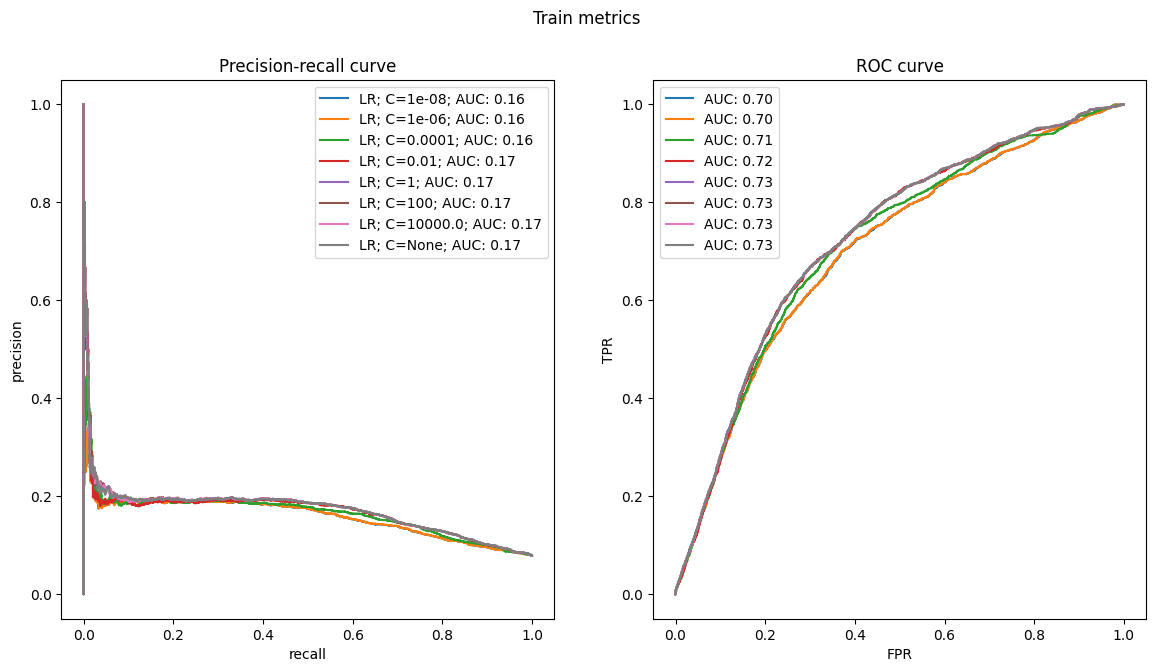

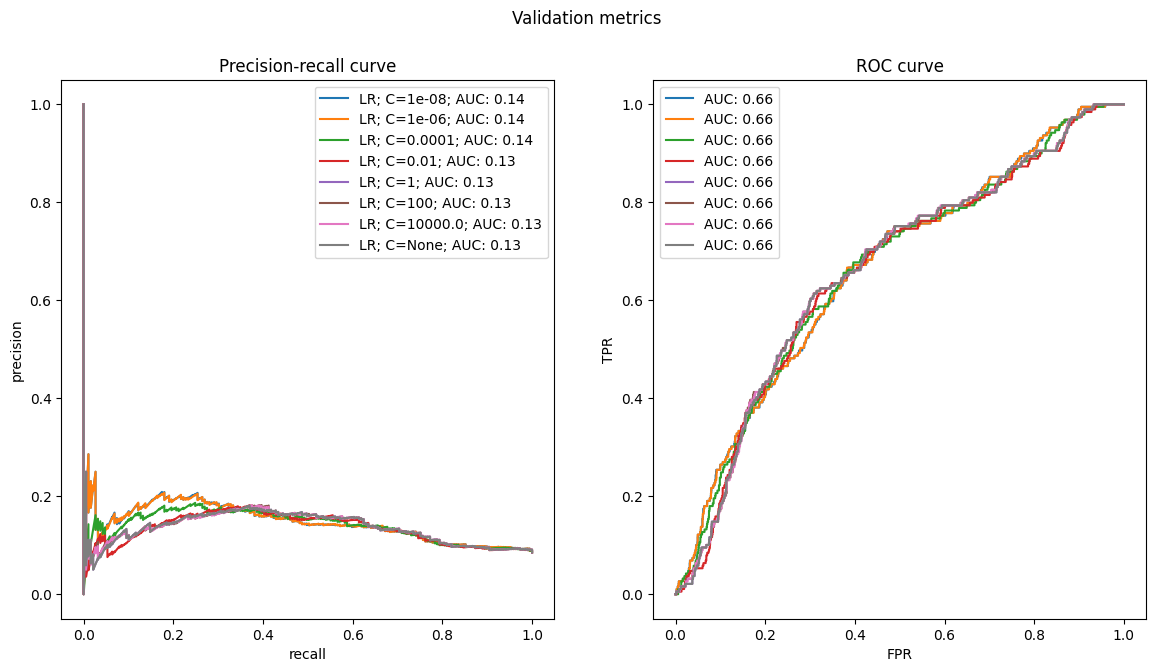

In [31]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



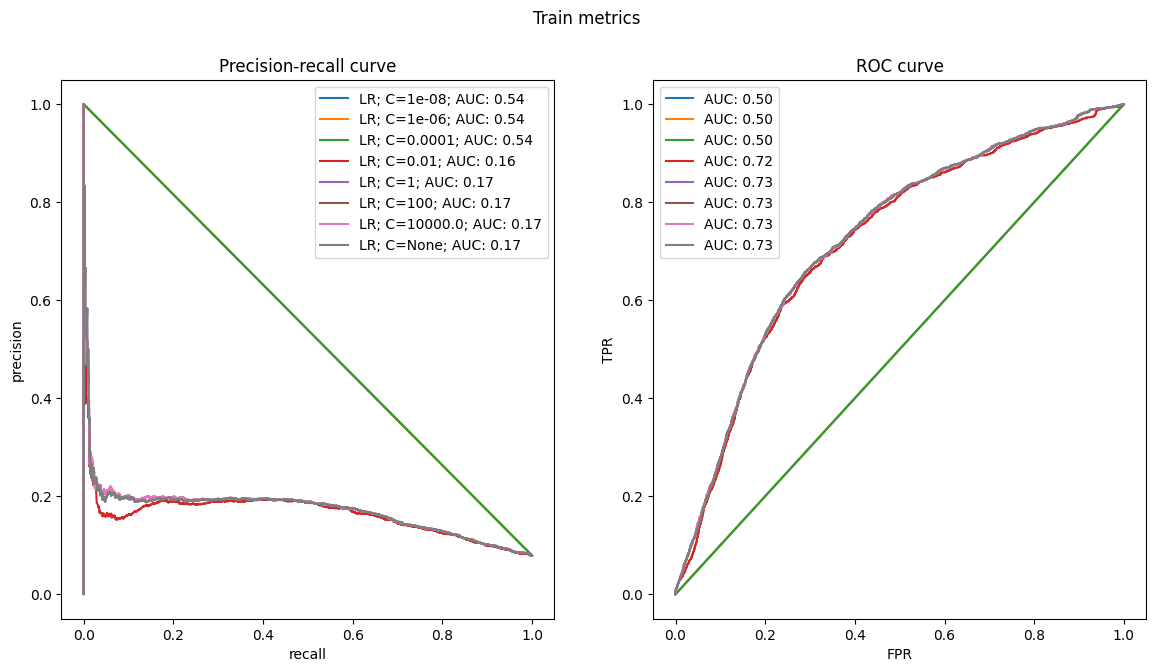

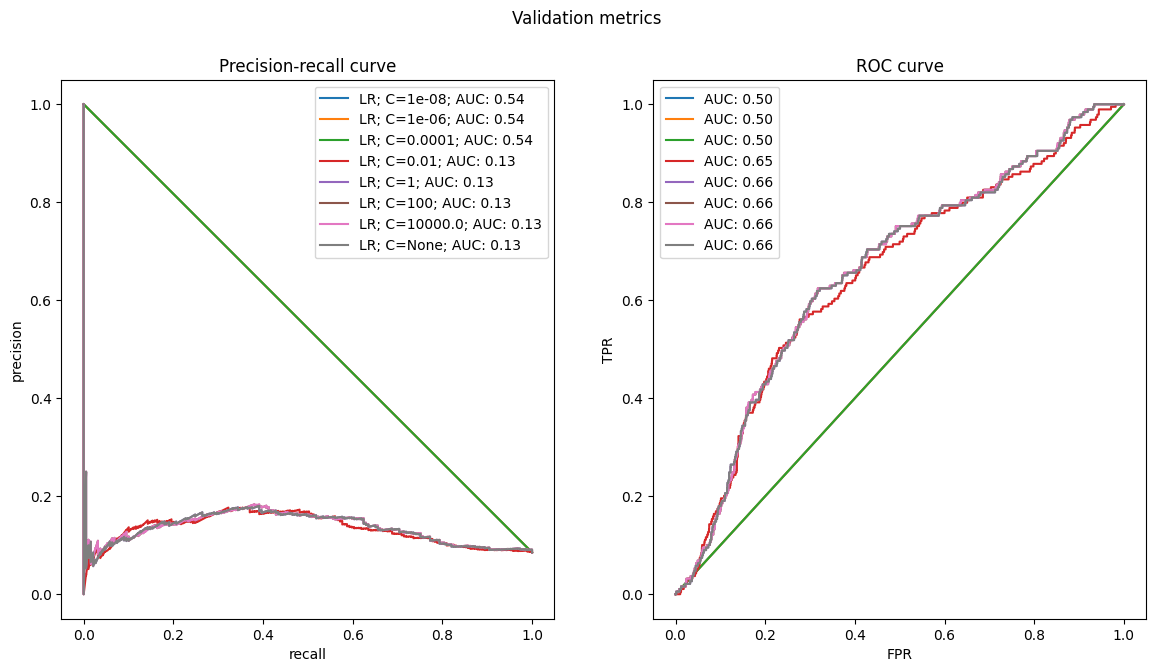

In [32]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l1", C=c if c else 1.0, solver='liblinear'),  # Cambiado a L1 y añadido solver
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )

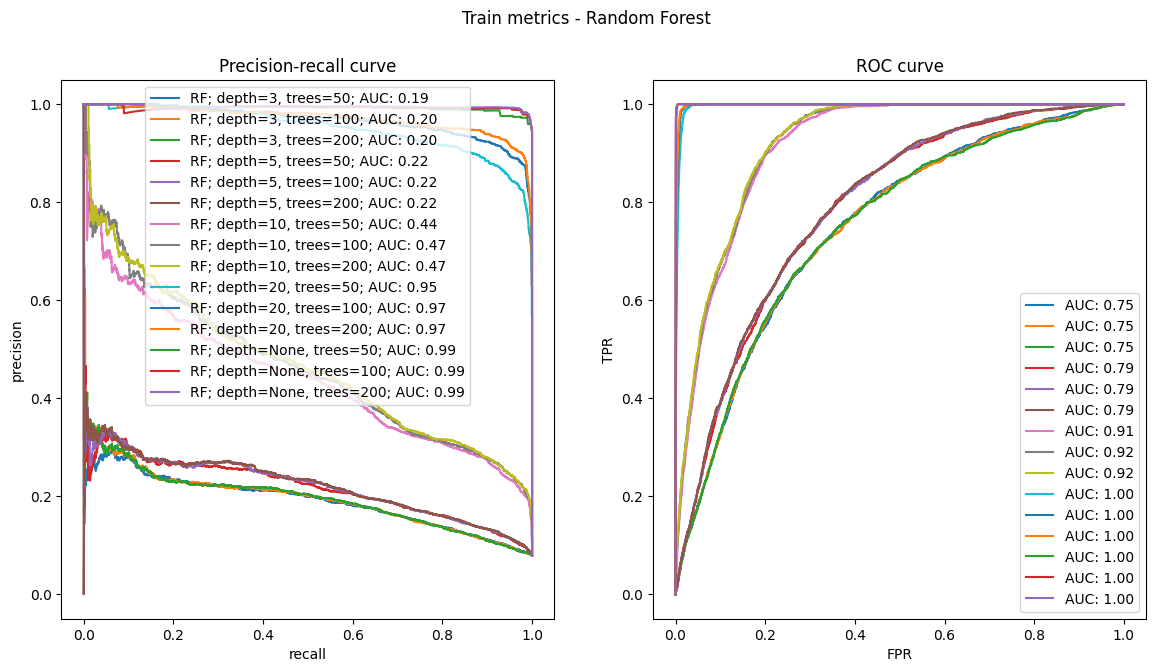

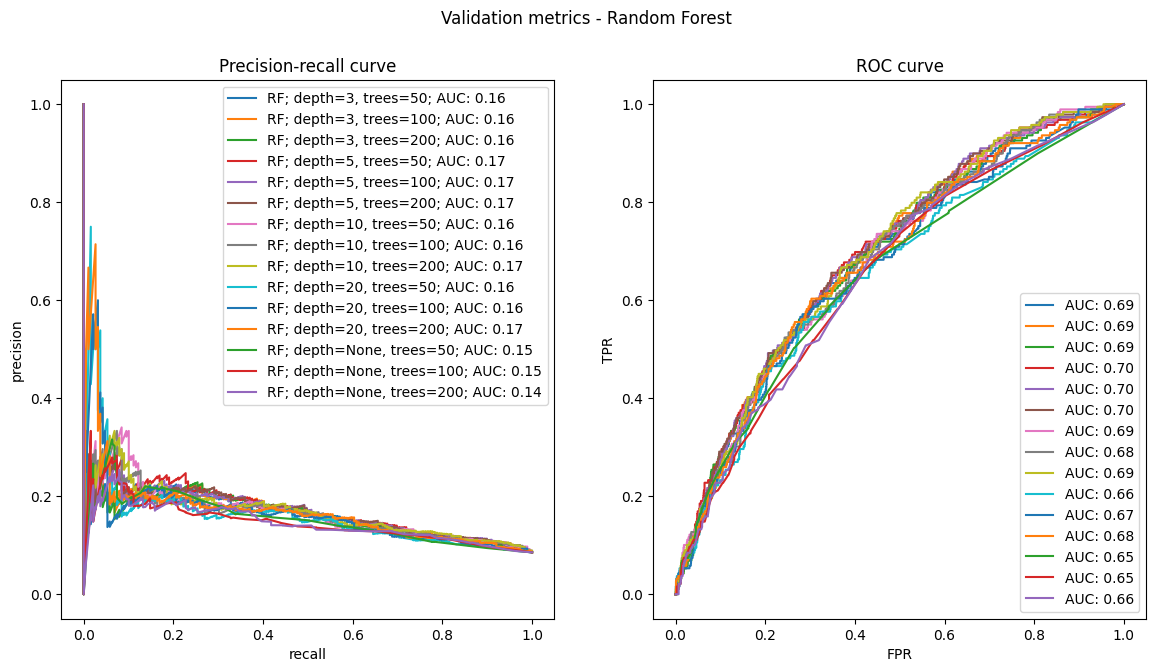

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Configurar parámetros a probar
max_depths = [3, 5, 10, 20, None]
n_estimators_list = [50, 100, 200]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=42,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[train_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )

